In [1]:
%%time
import sys;
import datetime
print('Starting at', datetime.datetime.now())
!{sys.executable} -m pip install -r requirements.txt
 

Starting at 2020-11-21 20:43:38.264597
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
CPU times: user 47.3 ms, sys: 10.1 ms, total: 57.4 ms
Wall time: 2.23 s


In [2]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()
print('Role', role)
print(f'Bucket {bucket} in region {region}')

Role arn:aws:iam::649592902942:role/service-role/AmazonSageMaker-ExecutionRole-20201021T144991
Bucket sagemaker-jfox in region eu-west-1
CPU times: user 790 ms, sys: 51.5 ms, total: 841 ms
Wall time: 2.88 s


In [3]:
%%time
import random
import pandas as pd
import pyarrow.parquet as pq

raw_data_filename = 'frauddetection.parquet.snappy'
 
s3 = boto3.resource('s3', region_name=region)

#s3_path = 'prepareddataalltypes/datapreparation_20Nov2020_1605858525820/datapreparation_20Nov2020_1605858525820_part00000.parquet.snappy'

#s3.Bucket(bucket).download_file(s3_path,  raw_data_filename)
 

CPU times: user 98.6 ms, sys: 8.18 ms, total: 107 ms
Wall time: 1.11 s


In [4]:
%%time 
table = pq.read_table(raw_data_filename)
df = table.to_pandas()
df = df.head(1000) #TODO FIX
    
    
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print(len(df), 'Data items')

1000 Data items
CPU times: user 1.17 s, sys: 801 ms, total: 1.97 s
Wall time: 663 ms


In [5]:
target_col='Fraudulent'

In [6]:

df = df.rename(columns = {'isFraud': target_col,
                          'type_CASH_OUT': 'type_CashOut',
                          'type_TRANSFER': 'type_Transfer',
                          'type_CASH_IN': 'type_CashIn',
                          'type_PAYMENT': 'type_Payment',
                          'oldbalanceOrg_nml': 'originOldBalance',
                          'oldBalanceOrigSign': 'originOldBalanceSign', 
                          'newbalanceOrig_nml': 'originNewBalance',
                          'negDeltaOrigin_nml': 'negativeDeltaInOrigin', 
                          'oldbalanceDest_nml': 'destinationOldBalance',
                          'newbalanceDest_nml': 'destinationNewBalance',
                          'expectedNewBalDest_nml': 'destinationExpectedNewBalance',#based on old value and delta   
                          'amount_nml': 'amount',
                          'hourOf24_radians': 'hourOf24_radians',# To be deleted after calculation
                          'isFlaggedFraud':'FlaggedFraud'#To be deleted
                         })


`type_X` columns where X in  `PAYMENT` `TRANSFER` `CASH_OUT` `DEBIT` `CASH_IN`
There was also `DEBIT`, but onehotting drops one of the types because of correlation.
All `isFraud` rows have `type` `TRANSFER` or `CASH_OUT`, never  `CASH_IN` or `PAYMENT` or `DEBIT`

Counts of each class to determine imbalance.

In [7]:
def count_positive_and_negative(df):
    num_positive = len(df.loc[  df[target_col] == 1 ])
    num_negative = len(df) - num_positive
    return num_positive, num_negative

num_positive, num_negative = count_positive_and_negative(df)

print('Fraud', num_positive, '; Not fraud', num_negative, '; Total', len(df))

Fraud 9 ; Not fraud 991 ; Total 1000


Plot distribution of positive vs negative, in log scale because of the imbalance

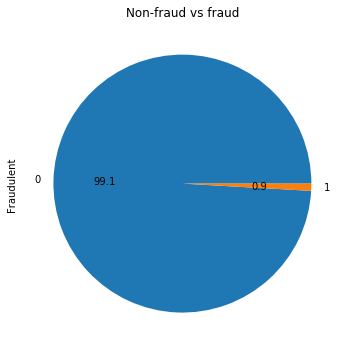

In [8]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
        df[target_col].value_counts().plot.pie(figsize=(5, 5), autopct='%.1f')
        plt.title('Non-fraud vs fraud')
        plt.tight_layout()
    
plot_positive_negative_counts(df,target_col)

Check that target is on the left, per Sagemaker standard

In [9]:
cols = df.columns.tolist()
assert cols[0]==target_col

Transform hour of day to a form suited for cyclical data

In [10]:
import numpy as np
hours_col = 'hourOf24_radians'
df['sineHourInDay'] = np.sin(df[hours_col])
df['cosineHourInDay'] = np.cos(df[hours_col])
df = df.drop(hours_col, axis=1)
df

,Fraudulent,type_CashIn,type_CashOut,type_Payment,type_Transfer,amount,originOldBalance,originOldBalanceSign,originNewBalance,negativeDeltaInOrigin,destinationOldBalance,destinationExpectedNewBalance,destinationNewBalance,sineHourInDay,cosineHourInDay
0,0,0,0,1,0,-0.281560,-0.229810,1,-0.237622,0.211876,-0.323814,-0.350732,-0.333411,0.258626,0.965977
1,0,0,0,1,0,-0.294767,-0.281359,1,-0.285812,0.157490,-0.323814,-0.352933,-0.333411,0.258626,0.965977
2,1,0,0,0,1,-0.297555,-0.288654,1,-0.292442,0.146011,-0.323814,-0.353398,-0.333411,0.258626,0.965977
3,1,0,1,0,0,-0.297555,-0.288654,1,-0.292442,0.146011,-0.317582,-0.347552,-0.333411,0.258626,0.965977
4,0,0,0,1,0,-0.278532,-0.274329,1,-0.282221,0.224345,-0.323814,-0.350227,-0.333411,0.258626,0.965977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,1,0,-0.294265,-0.283984,1,-0.288508,0.159556,-0.323814,-0.352850,-0.333411,0.258626,0.965977
996,0,0,0,1,0,-0.281727,-0.188397,1,-0.196681,0.211189,-0.323814,-0.350760,-0.333411,0.258626,0.965977
997,0,0,0,1,0,-0.292230,-0.282303,1,-0.287268,0.167937,-0.323814,-0.352510,-0.333411,0.258626,0.965977
998,0,0,0,1,0,-0.286625,-0.270491,1,-0.276758,0.191017,-0.323814,-0.351576,-0.333411,0.258626,0.965977


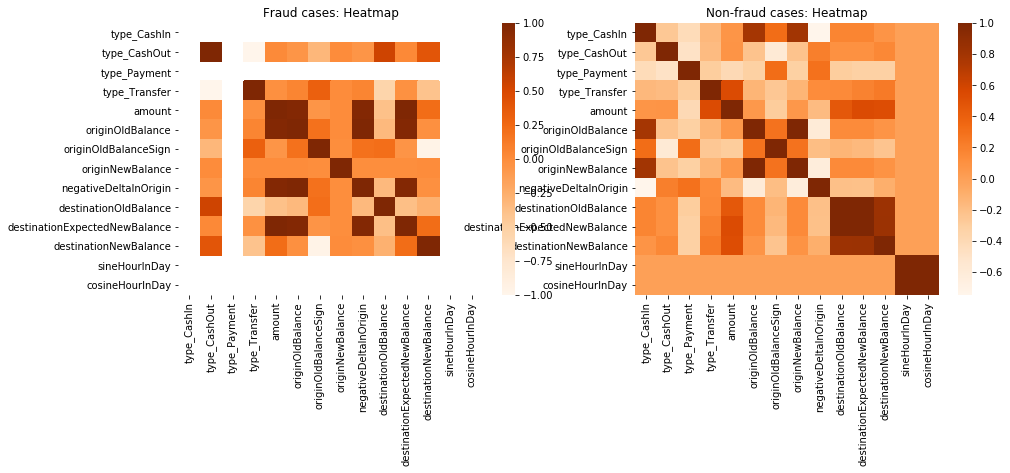

In [11]:
import seaborn  

fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl='Fraud' if  fraud_cases else 'Non-fraud'
    # Coerced to int, below
    axes[1-fraud_cases].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'{target_col} == {fraud_cases}').drop([target_col], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

Optionally use *SMOTENC* for unbalanced classes, though we may stick with the XGBoost parameters.

In [12]:
%%time 

from imblearn.over_sampling import SMOTENC

use_smote = False # Can just use weighting in XGBOOST instead of SMOTENC

if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

CPU times: user 165 ms, sys: 16.1 ms, total: 181 ms
Wall time: 180 ms


# Split  with randomization

In [13]:
import numpy as np
len_ = len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

All Fraudulent cases have `type_Transfer` or `type_CashOut`. We train only on items with those types.

At runtime, we mark as non-Fraudulent those where type is not `type_Transfer` or `type_CashOut`. Where the type is one of those, we use ML.

In [14]:
print('Before filtering, data items', len(train_data), 'training and', len(validation_data), 'validation data', len(test_data),'test ')

train_data = train_data[(train_data['type_Transfer'] == 1) | (train_data['type_CashOut'] == 1)]

validation_data = validation_data[(validation_data['type_Transfer'] == 1) | (validation_data['type_CashOut'] == 1)]

test_data_ml = test_data[(test_data['type_Transfer'] == 1) | (test_data['type_CashOut'] == 1)]

test_data_for_rules = test_data[(test_data['type_Transfer'] == 0) & (test_data['type_CashOut'] == 0)]

print('After filtering, items:', len(train_data), 'training and ', len(validation_data), 'validation and ',
      len(test_data_ml),'test for ML and ', len(test_data_for_rules), 'test for rules')

Before filtering, 700 training data and 200 validation data and 100 test data
After filtering, 229 training data and  64 validation data and  36 test data for ML and  64 test data for rules


Using libSVM for performance.

In [15]:
%%time
from sklearn.datasets import dump_svmlight_file   

lengths = [] 

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data_ml, 'test.libsvm')]:
   dataset=d[0]
   file_ = d[1]
   lengths.append((d[1].split('.')[0],len(dataset)))
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])

print('Length of datasets:', lengths )

s3 = boto3.resource('s3', region_name=region) 

for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

Length of datasets: [('train', 229), ('validation', 64), ('test', 36)]
CPU times: user 85.8 ms, sys: 1.2 ms, total: 87 ms
Wall time: 189 ms


In [16]:
def s3_path(subset):
  return sagemaker.TrainingInput(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

---
## Train

To train, first set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.

In [17]:
from sagemaker.amazon.amazon_estimator import get_image_uri

import math

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)
num_positive, num_negative=count_positive_and_negative(train_data)
scale_pos_weight=math.sqrt(num_negative / num_positive )
print(f'num_positive: {num_positive}, num_negative: {num_negative}, scale_pos_weight {scale_pos_weight:.1f}')

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        gamma=4,
                        subsample=0.5,
                        eval_metric='aucpr',     
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        num_round=200, 
                        silent=0)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


num_positive: 6, num_negative: 223, scale_pos_weight 6.1


Run the `fit` training  or hypertuned-training job.

In [18]:
%%time
hypertune = False
import pprint

if not hypertune:
    result = xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
    training_job_name = xgb._current_job_name
else:
    import time

    from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
    hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}


    objective_metric_name = 'validation:f1'

    tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, 
                            base_tuning_job_name='hypertune',
                            max_parallel_jobs=10)
    
    print('Starting hypertuning job')
    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False, wait=False)
    print('Started hypertuning job', tuner.latest_tuning_job.job_name)

    counter = 0
    status = 'InProgress'
    while status == 'InProgress':
        tuning_job_result=boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
           HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)
        counter += 0.5
        time.sleep(30)   
        status = tuning_job_result['HyperParameterTuningJobStatus']
        print(f'{counter} min., {status};', end=' ')
        
    if 'BestTrainingJob' in tuning_job_result:
       training_job_name = tuning_job_result['BestTrainingJob']['TrainingJobName']
    else:
       raise Exception(f'No best job identified {tuning_job_result}')


2020-11-21 20:43:47 Starting - Starting the training job...
2020-11-21 20:43:49 Starting - Launching requested ML instances......
2020-11-21 20:44:53 Starting - Preparing the instances for training...
2020-11-21 20:45:47 Downloading - Downloading input data...
2020-11-21 20:46:06 Training - Downloading the training image...
2020-11-21 20:46:44 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value aucpr to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[20:46:41] 229x14 matrix with 2345 entries loaded from /opt/ml/input/data/train
[20:46:41] 64x14 matrix with 656 entries loa

---
## Host

Deploy the trained model to an endpoint.

In [19]:
import datetime 
import time

endpoint_name = 'fraud-detect-endpoint'
model_name = training_job_name + '-model'

info = session.describe_training_job(training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
  'Image': container,
  'ModelDataUrl': model_data
}

create_model_response = session.create_model(
      name = model_name,
      role = role,
      container_defs = primary_container)


endpoint_config_name = session.create_endpoint_config(name=endpoint_name + '-config-' + datetime.datetime.now().strftime('%m%d-%H%M%S'),
                                              model_name=model_name,
                                              initial_instance_count=1,
                                              instance_type='ml.m5.xlarge',
                                              accelerator_type='ml.eia2.medium')

client = boto3.client('sagemaker')
counter = 0
try_now = True
while try_now:
  counter += 0.5
  try:
     updated_endpoint = client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
     try_now = False
  except Exception as e:
     if 'Could not find endpoint'  in str(e):
        print('Could not find endpoint; Trying to create')
        updated_endpoint=client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
        try_now = False
     elif 'Cannot update in-progress endpoint' in str(e):
        print(f'{counter} min: Cannot update in-progress endpoint; retrying', end='. ')
        time.sleep(30)
        try_now = True
     else:  
        raise e

endpt_status = 'Updating'
counter = 0 
while endpt_status in ['Updating', 'Creating']:
    counter += 0.5
    endpt_status = client.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
    print(f'{counter} min: {endpt_status} endpoint; ',end='')
    time.sleep(30)

print('\nFinished creating or updating endpoint')

s3://sagemaker-jfox/sagemaker/xgboost/output/fraud-detection-job-2020-11-21-20-43-47-138/output/model.tar.gz
0.5 min: Updating endpoint; 1.0 min: Updating endpoint; 1.5 min: Updating endpoint; 2.0 min: Updating endpoint; 2.5 min: Updating endpoint; 3.0 min: Updating endpoint; 3.5 min: Updating endpoint; 4.0 min: Updating endpoint; 4.5 min: Updating endpoint; 5.0 min: Updating endpoint; 5.5 min: Updating endpoint; 6.0 min: Updating endpoint; 6.5 min: Updating endpoint; 7.0 min: InService endpoint; 
Finished creating or updating endpoint


In [37]:
from sagemaker.predictor import csv_serializer
from sagemaker.serializers import LibSVMSerializer


xgb_predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, 
    serializer=LibSVMSerializer(),
    sagemaker_session=sagemaker.Session()
)


---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [38]:
def batch_predict(data, batch_size):

    def do_predict(data):
       payload = '\n'.join(data)
       response = xgb_predictor.predict(payload).decode('utf-8')
       result = response.split(',')
       preds = [float(num) for num in result]
       preds = [round(num) for num in preds]
       return preds

    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [39]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels_ml = [int(line.split(' ')[0]) for line in payload.split('\n')]

test_data_input_for_ml = [line for line in payload.split('\n')]
preds_ml = batch_predict(test_data_input_for_ml, 100)

.CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 69.3 ms


In [44]:
labels_rule_based = list(test_data_for_rules[target_col])
unexpected_pos = [lbl for lbl in labels_rule_based if lbl!=0 ]
assert 0 == len(unexpected_pos), 'Expect all to be negative for these "types"'
preds_rule_based = labels_rule_based.copy()

In [45]:
labels_all = labels_ml + labels_rule_based
preds_all = preds_ml + preds_rule_based

In [60]:
def metrics(labels_, predictions):
    assert len(labels_)==len(predictions)
    
    print(f'n = {len(labels_)}')
   
    actual_pos = sum(1 for i in range(len(labels_)) if 1 == labels_[i])
    actual_neg = sum(1 for i in range(len(labels_)) if 0 == labels_[i])

    pred_pos = sum(1 for i in range(len(predictions)) if 1 == predictions[i])
    pred_neg = sum(1 for i in range(len(predictions)) if 0 == predictions[i])

    true_pos = sum(1 for i in range(len(predictions)) if predictions[i] == 1 == labels_[i])
    true_neg = sum(1 for i in range(len(predictions)) if predictions[i] == 0 == labels_[i])

    false_pos=sum(1 for i in range(len(predictions)) if predictions[i] == 1 and 0 == labels_[i])
    false_neg=sum(1 for i in range(len(predictions)) if predictions[i] == 0 and 1 == labels_[i])
    print('true_pos', true_pos, 'false_pos', false_pos)
    print('true_neg', true_neg, 'false_neg', false_neg)

    assert  true_pos+false_pos == pred_pos
   
    recall = true_pos / (true_pos + false_neg)
    print(f'Recall = {recall:.2f}')
    precision = true_pos / (true_pos + false_pos)

    print(f'Precision = {precision:.2f}')
    if precision+recall == 0:
        f1=float('inf')
    else:
        f1 = (2 * precision * recall) / (precision + recall)
        
    print(f'F1 = {f1:.2f}')
    error = sum(1 for i in range(len(predictions)) if predictions[i] != labels_[i]) / float(len(predictions))
    print(f'Error rate = {error:.2f}')

    assert recall <= f1 <= precision or precision <= f1 <= recall  or precision==recall==0
    assert true_pos + false_neg == actual_pos
    assert true_neg + false_pos == actual_neg
    #print('pred_pos', pred_pos,'pred_neg', pred_neg)

    assert len(predictions)==len(labels_)

    #print(len(predictions), 'predictions and labels_')

    #print('actual_pos', actual_pos, 'actual_neg', actual_neg)
    assert actual_pos + actual_neg==len(labels_)


    #print('true_neg', true_neg, 'false_neg', false_neg )
    assert true_neg + false_neg== pred_neg

    #print('pred_pos+pred_neg',pred_pos+pred_neg)
    assert pred_pos + pred_neg==len(predictions)
 



print('ML-based metrics')
metrics(labels_ml, preds_ml)
print('Full  metrics') 
metrics(labels_all, preds_all)


ML-based metrics
n = 36
true_pos 0 false_pos 1
true_neg 34 false_neg 1
Recall = 0.00
Precision = 0.00
F1 = inf
Error rate = 0.06
Full  metrics
n = 100
true_pos 0 false_pos 1
true_neg 98 false_neg 1
Recall = 0.00
Precision = 0.00
F1 = inf
Error rate = 0.02


Show confusion matrix.

In [ ]:
pd.crosstab(index=np.array(labels_all), columns=np.array(preds_all), rownames=['actual fraud'],  colnames=['predicted as fraud'])

Clean up to save money

In [ ]:
#session.delete_endpoint(xgb_predictor.endpoint)